### Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, fbeta_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from pathlib import Path
from sklearn.model_selection import learning_curve

### Carga de datos

In [2]:
df = pd.read_csv('../data/processed/final_dataset.csv')

### Division del dataset (train - test)

In [3]:
X = df.drop(columns=['nicotine', 'nicotine_label', 'target'])  
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

### Procesamiento de Datos

#### Generacion de variable para la calidad del dato

In [4]:
# Debido a la presencia de nulos, se establece un "indice de calidad" del registro. Se imputa con la mediana.

def preprocess_data(X_train, X_test):
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()

    nan_cols = X_train.columns[X_train.isna().any()].tolist()


    for col in nan_cols:
        X_train_clean[f"{col}_missing"] = X_train_clean[col].isna().astype(int)
        X_test_clean[f"{col}_missing"] = X_test_clean[col].isna().astype(int)


    imputer = SimpleImputer(strategy='median')
    X_train_clean[nan_cols] = imputer.fit_transform(X_train_clean[nan_cols])
    X_test_clean[nan_cols] = imputer.transform(X_test_clean[nan_cols])


    X_train_clean["missing_rate"] = X_train_clean[[f"{c}_missing" for c in nan_cols]].mean(axis=1)
    X_test_clean["missing_rate"] = X_test_clean[[f"{c}_missing" for c in nan_cols]].mean(axis=1)

    return X_train_clean, X_test_clean

#### Optimizacion del threshold (para amortiguar el desbalanceo de clases)

In [5]:
def find_best_threshold(y_true, y_probs, beta=2.0):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-9)
    best_idx = np.nanargmax(f_beta)
    return thresholds[best_idx], f_beta[best_idx]


#### Optimizacion LightGBM

In [6]:
def objective_lgb(trial, X, y):
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 30),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 15.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 15.0, log=True),
        'random_state': 42,
        'early_stopping_rounds': 30,
        'verbose_eval': False
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for tr_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        dtr = lgb.Dataset(X_tr, label=y_tr)
        dval = lgb.Dataset(X_val, label=y_val)
        model = lgb.train(params, dtr, valid_sets=[dval])
        preds = model.predict(X_val)
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

#### Optimizacion de XGBoost

In [7]:
def objective_xgb(trial, X, y):
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-0, log=True),
        'max_depth': trial.suggest_int("max_depth", 3, 20),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 50),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'lambda': trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float("alpha", 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_estimators': 1000,
        'early_stopping_rounds': 30
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for tr_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

#### Pipeline Principal

In [8]:
def main_pipeline(X_train, X_test, y_train, y_test):

    X_train_clean, X_test_clean = preprocess_data(X_train, X_test)

    print("Optimizing LightGBM...")
    study_lgb = optuna.create_study(direction='maximize')
    study_lgb.optimize(lambda trial: objective_lgb(trial, X_train_clean, y_train), n_trials=50)
    best_lgb = study_lgb.best_params
    best_lgb.update({
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    })
    final_lgb = lgb.LGBMClassifier(**best_lgb)
    final_lgb.fit(X_train_clean, y_train)

    print("Optimizing XGBoost...")
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(lambda trial: objective_xgb(trial, X_train_clean, y_train), n_trials=50)
    best_xgb = study_xgb.best_params
    best_xgb.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    })
    final_xgb = xgb.XGBClassifier(**best_xgb)
    final_xgb.fit(X_train_clean, y_train)

    stack = StackingClassifier(
        estimators=[('lgb', final_lgb), ('xgb', final_xgb)],
        final_estimator=LogisticRegression(max_iter=1000),
        passthrough=True
    )
    stack.fit(X_train_clean, y_train)

    vote = VotingClassifier(
        estimators=[('lgb', final_lgb), ('xgb', final_xgb)],
        voting='soft'
    )
    vote.fit(X_train_clean, y_train)

    models = {
        "LightGBM": final_lgb,
        "XGBoost": final_xgb,
        "Stacking": stack,
        "Voting": vote
    }


    return models, X_train_clean, X_test_clean, study_lgb, study_xgb

In [9]:
models, X_train_clean, X_test_clean, study_lgb, study_xgb = main_pipeline(X_train, X_test, y_train, y_test)

[I 2025-07-04 22:55:03,465] A new study created in memory with name: no-name-9dd6eb11-a51a-4208-9070-d2b13df1621e


Optimizing LightGBM...


[I 2025-07-04 22:55:04,206] Trial 0 finished with value: 0.7230961959496442 and parameters: {'learning_rate': 0.013379419555375765, 'num_leaves': 282, 'min_child_samples': 35, 'feature_fraction': 0.9323331494338049, 'bagging_fraction': 0.6655516762848501, 'bagging_freq': 18, 'lambda_l1': 0.0008925086735576189, 'lambda_l2': 0.00036545447802479626}. Best is trial 0 with value: 0.7230961959496442.
[I 2025-07-04 22:55:04,479] Trial 1 finished with value: 0.7221918103448276 and parameters: {'learning_rate': 0.0030053790774776565, 'num_leaves': 164, 'min_child_samples': 187, 'feature_fraction': 0.46406886200123515, 'bagging_fraction': 0.4451377777661167, 'bagging_freq': 29, 'lambda_l1': 0.027276284467572416, 'lambda_l2': 6.716694545760411e-05}. Best is trial 0 with value: 0.7230961959496442.
[I 2025-07-04 22:55:04,837] Trial 2 finished with value: 0.7392021072796935 and parameters: {'learning_rate': 0.8408100509845862, 'num_leaves': 90, 'min_child_samples': 246, 'feature_fraction': 0.8987305

Optimizing XGBoost...


[I 2025-07-04 22:55:30,898] Trial 0 finished with value: 0.7447066228790366 and parameters: {'learning_rate': 0.1144588819979475, 'max_depth': 7, 'min_child_weight': 40, 'subsample': 0.7977075319839183, 'colsample_bytree': 0.7282038362383529, 'lambda': 6.30903175200156e-05, 'alpha': 1.1253396926385066e-05}. Best is trial 0 with value: 0.7447066228790366.
[I 2025-07-04 22:55:32,369] Trial 1 finished with value: 0.7348958333333333 and parameters: {'learning_rate': 0.00444369852929909, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5882114507901424, 'colsample_bytree': 0.6076280756607195, 'lambda': 0.24441894269429137, 'alpha': 5.698955994279802}. Best is trial 0 with value: 0.7447066228790366.
[I 2025-07-04 22:55:33,602] Trial 2 finished with value: 0.7477216406677615 and parameters: {'learning_rate': 0.01662610463386779, 'max_depth': 14, 'min_child_weight': 38, 'subsample': 0.7897822853793777, 'colsample_bytree': 0.833721092556183, 'lambda': 0.004488987341548375, 'alpha': 0.00133

#### Evaluacion de la optimizacion de hiperpatametros - LightGBM

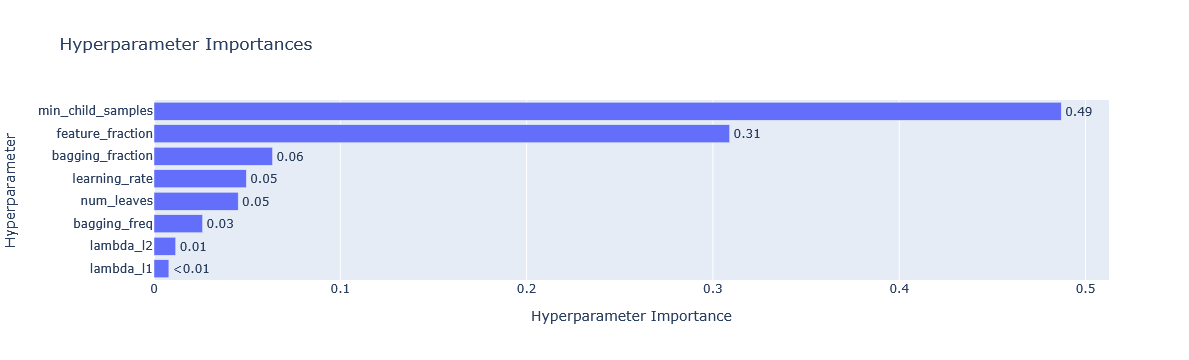

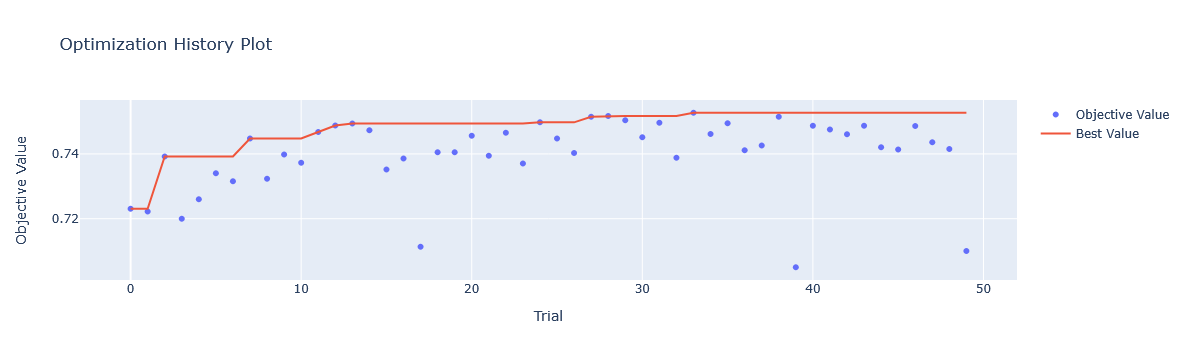

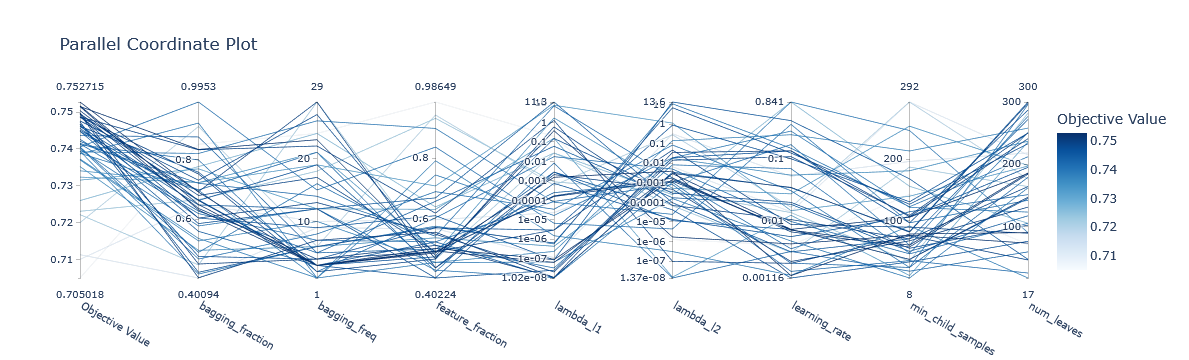

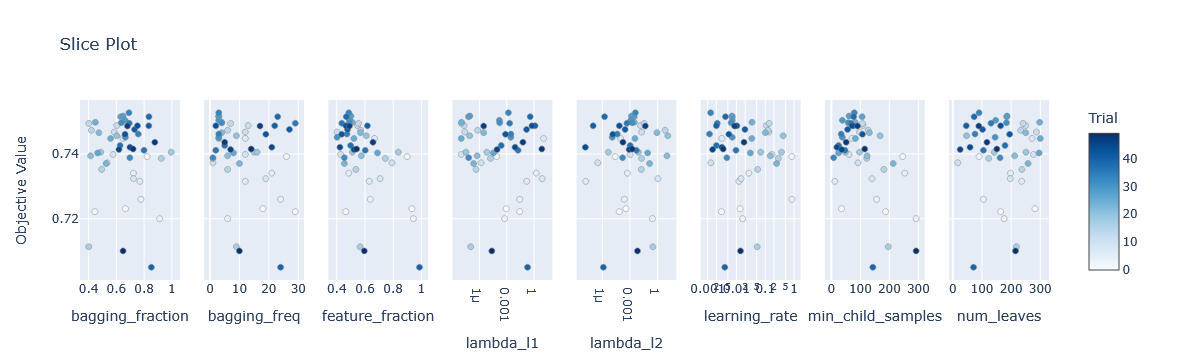

In [10]:
optuna.visualization.plot_param_importances(study_lgb).show()
optuna.visualization.plot_optimization_history(study_lgb).show()
optuna.visualization.plot_parallel_coordinate(study_lgb).show()
optuna.visualization.plot_slice(study_lgb).show()

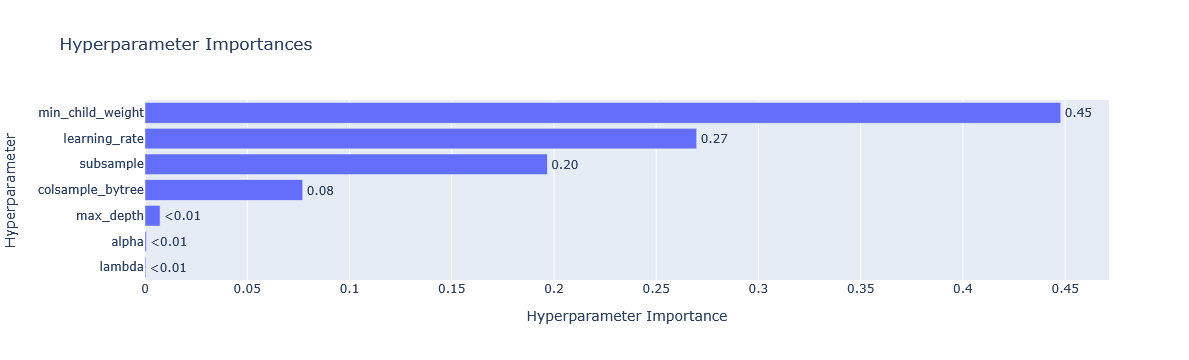

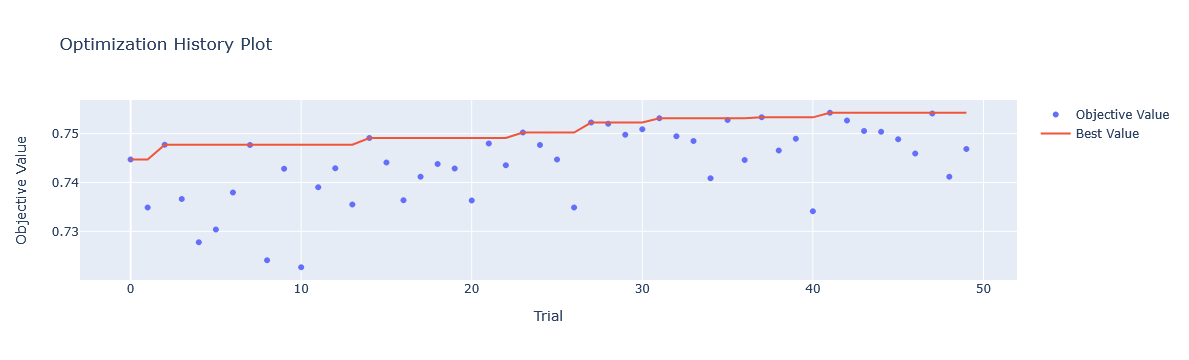

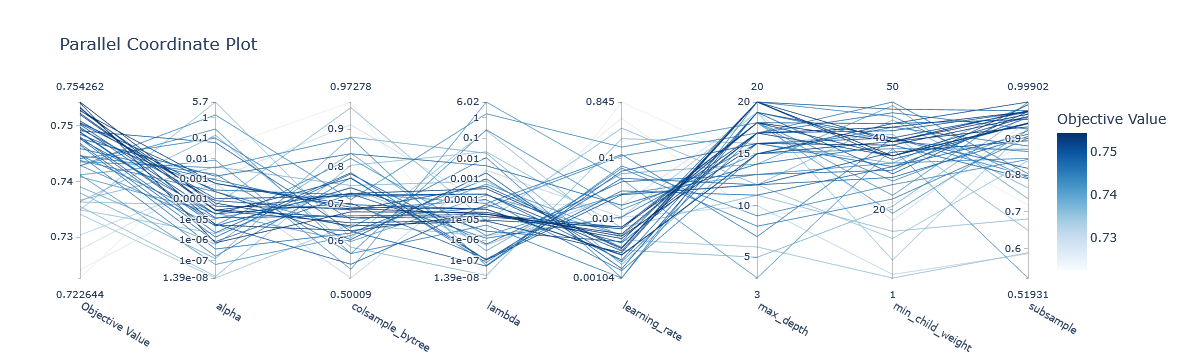

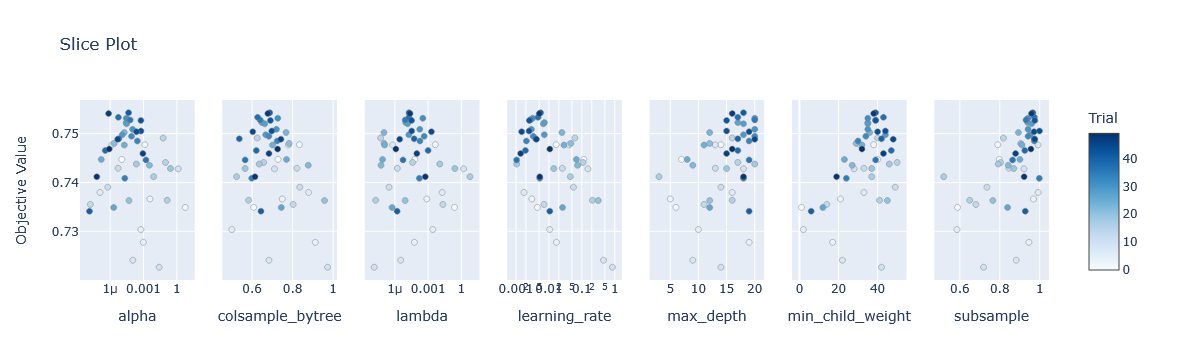

In [11]:
optuna.visualization.plot_param_importances(study_xgb).show()
optuna.visualization.plot_optimization_history(study_xgb).show()
optuna.visualization.plot_parallel_coordinate(study_xgb).show()
optuna.visualization.plot_slice(study_xgb).show()

####  Evaluacion de la optimizacion de hiperpatametros - XGBoost

### Evaluacion del Ajuste

Evaluando curva de aprendizaje para LightGBM


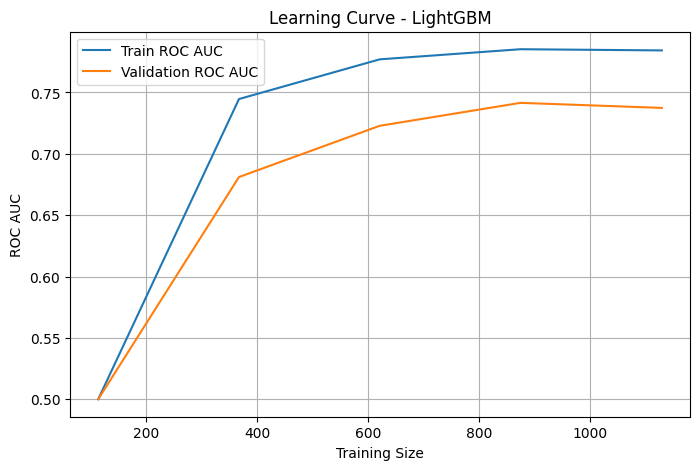

Evaluando curva de aprendizaje para XGBoost


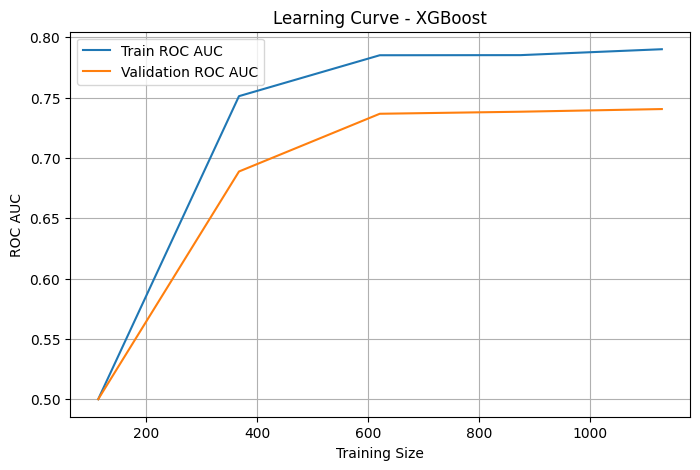

Evaluando curva de aprendizaje para Stacking


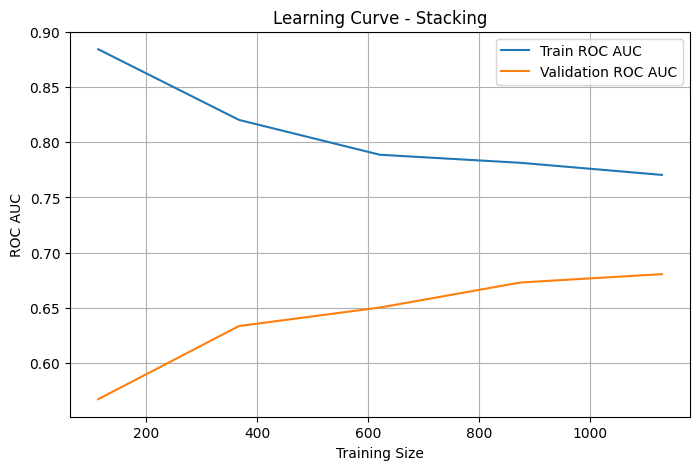

Evaluando curva de aprendizaje para Voting


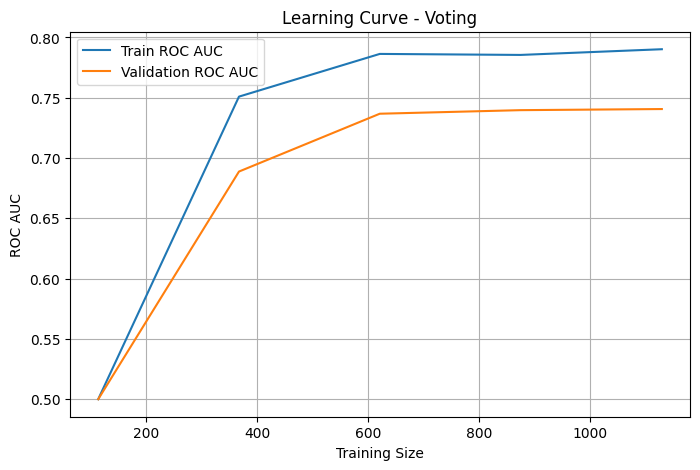

In [12]:
def plot_learning_curve(estimator, X, y, name):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=5, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 5))
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Train ROC AUC")
    plt.plot(train_sizes, val_mean, label="Validation ROC AUC")
    plt.title(f"Learning Curve - {name}")
    plt.xlabel("Training Size")
    plt.ylabel("ROC AUC")
    plt.legend()
    plt.grid()
    plt.show()
    
    
for name, model in models.items():
    print(f"Evaluando curva de aprendizaje para {name}")
    plot_learning_curve(model, X_train_clean, y_train, name)

### Guardo los modelos y el dataset procesados

In [13]:

Path("models").mkdir(exist_ok=True)

joblib.dump(X_train_clean, "../models/X_train_clean.pkl")
joblib.dump(X_test_clean, "../models/X_test_clean.pkl")


for name, model in models.items():
    joblib.dump(model, f"../models/final_{name.lower()}.pkl")